# Analysis
**Mt Hay, Blue Mountains NSW - Change Detection 2019 to 2023**

Author: Michael Dear, April 2024

## Usage
This notebook should be run after completing the [Dataset Extraction](dataset_extraction.ipynb) notebook and exporting the data as `.nc`. The Analysis notebook can be run by first downloading the two `.nc` files exported from the Data Extraction notebook, or from within the [Digital Earth Australia Sandbox](https://app.sandbox.dea.ga.gov.au/).

## Setup

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import xarray as xr
import rioxarray
import numpy as np
import pandas as pd
import geopandas as gpd

# Turn off warnings
import warnings
warnings.filterwarnings('ignore')

### Global Parameters
* Global parameters are used in multiple places
* Local parameters should be found above the relevant code

In [47]:
netcdf_dir = '../data/netcdf/'
img_dir = '../data/img/'
vector_dir = '../data/vector/'
geotiff_dir = '../data/geoTIFF/'

area_unit = 'ha'
area_unit_val = 10**4

spatial_res = 10 # Spatial resolution of the raster dataset in metres
crs = 3577

# First and last years
years = [2019, 2023]

# Study area abbreviation for exports etc
study_area_abbrev = 'mt_hay'


# Class labels
cl_labels = ['Water', 'Bare', 'Sparse', 'Medium-density', 'High-density', 'Masked']

## Step 1: Load data

In [15]:
ds=xr.load_dataset(netcdf_dir+study_area_abbrev+'_'+str(years[0])+'_'+str(years[1])+'.nc')

In [16]:
mask = xr.load_dataarray(netcdf_dir+'mask.nc')

In [17]:
# Load the polygon
poly = gpd.read_file(vector_dir+study_area_abbrev+'.geojson')

# Set the crs to 4326, then convert to projected crs
poly = poly.set_crs(4326).to_crs(crs)

## Step 2: Plots
<a id='plots'></a>
The following plots compare the current year to the 5-year mean and the previous year. High-resolution versions are saved in the `ouput` directory for closer visual assessment. The plots are a quicker alternative than loading the exported geoTIFF's into a GIS.

### Plotting Parameters and Functions

In [48]:
# Bands for standard RGB plots
rgb_vars = ['nbart_red', 'nbart_green', 'nbart_blue']

# Main plot parameters
rgb_params = {
    'robust':True,
}

ndvi_params = {
    'robust':True,
    'cmap':'RdYlGn',
    'add_colorbar':False,
    'vmin':0,
    'vmax':1
}

ndvi_class_params = {
    'levels':[1,2,3,4,5,6], 
    'cmap':'RdYlGn',
    'add_colorbar':False,
}

In [49]:
def remove_labels_ticks(ax):
    '''
    Remove axis labels and ticks from subplots.
    '''
    ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    ax.set_xlabel('')
    ax.set_ylabel('')

### True-colour (RGB)
*Note*: For `imshow`, the rgb values need to be converted to decimal by dividing by $2^{12}$ (Sentinel 2 is 12 bit), then scaling to 255 before converting to `np.uint8`. See https://stackoverflow.com/questions/49643907/clipping-input-data-to-the-valid-range-for-imshow-with-rgb-data-0-1-for-floa

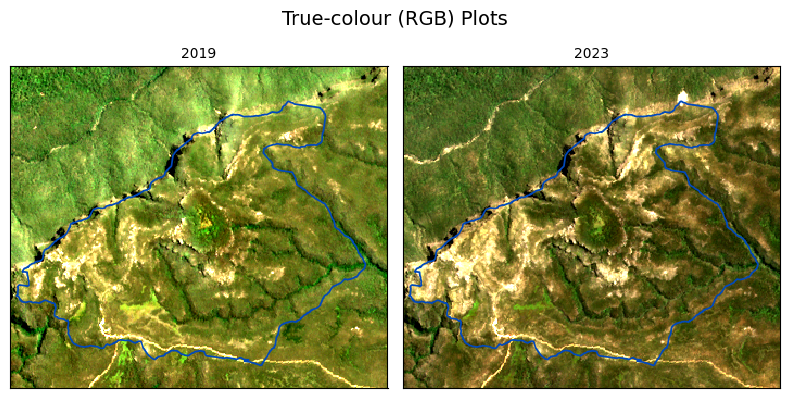

In [64]:
fig, axes = plt.subplots(1,2, figsize=(8,5))

for i, year in enumerate(years):
    (
     ds[rgb_vars]
     .sel(year=year)
     .to_array()
     .plot
     .imshow(ax=axes[i], **rgb_params)
    )

for i, ax in enumerate(axes.flat):
    remove_labels_ticks(ax)
    ax.set_title(str(years[i]), fontsize=10)
    poly.boundary.plot(ax=ax, linewidth=1.25, color='#0249ba')
    
fig.suptitle('True-colour (RGB) Plots', y=0.9, fontsize=14)
fig.tight_layout()

# bbox_inches = "tight" is required to stop labels at edges being cut off
# https://stackoverflow.com/questions/35992492/savefig-cuts-off-title
fig.savefig(img_dir+'RGB_plots.png', dpi=600, bbox_inches = "tight");

plt.show()
plt.close('all')

### NDVI

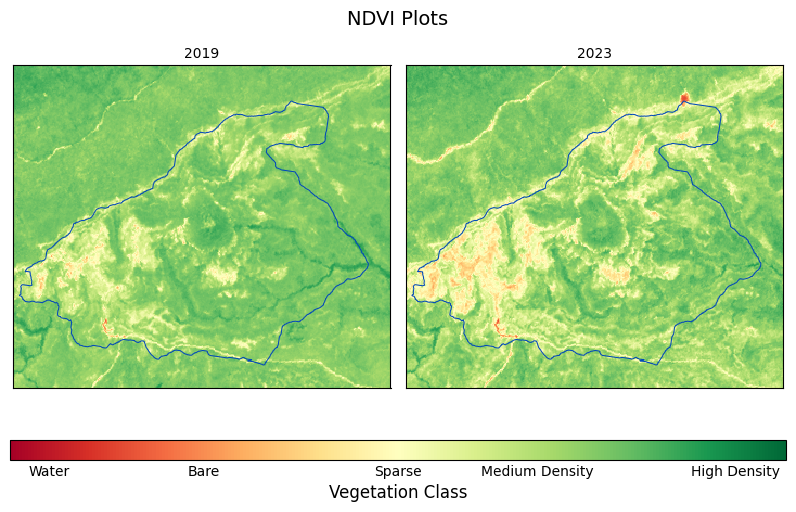

In [65]:
fig, axes = plt.subplots(1,2, figsize=(8,5))

years = ds.year.values

for i, year in enumerate(years):
    colour = (ds
     .NDVI
     .sel(year=year)
     .plot(ax=axes[i], **ndvi_params)
    )

for i, ax in enumerate(axes.flat):
    remove_labels_ticks(ax)
    ax.set_title(str(years[i]), fontsize=10)
    poly.boundary.plot(ax=ax, linewidth=0.75, color='#0249ba')


# Add colorbar - horizontal at bottom
cax = fig.add_axes([0.015, 0, 0.97, 0.04]) # Horizontal at bottom
cb = fig.colorbar(
                          colour, 
                          cax=cax, 
                          orientation = 'horizontal', 
                         )

cb.set_ticks([0.05, 0.25, 0.5, 0.68, 0.935])
cb.set_ticklabels(cl_labels[:-1])
cb.ax.tick_params(size=0)
cb.set_label('Vegetation Class', fontsize=12)

fig.suptitle('NDVI Plots', y=0.9, fontsize=14)
fig.tight_layout()

# bbox_inches = "tight" is required to stop labels at edges being cut off
# https://stackoverflow.com/questions/35992492/savefig-cuts-off-title
fig.savefig(img_dir+'NDVI_plots.png', dpi=600, bbox_inches = "tight");

plt.show()
plt.close('all')

### NDVI Classification

In [770]:
np.unique(ds.NDVI_Class)

array([2, 3, 4, 5], dtype=int16)

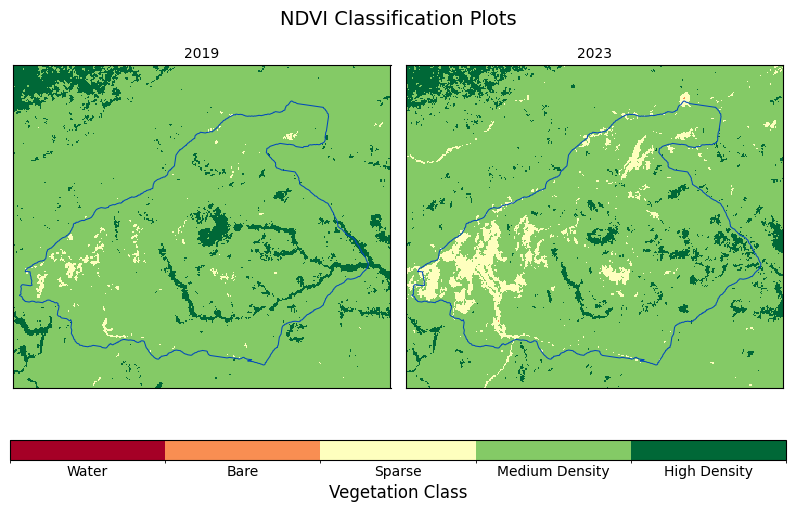

In [66]:
fig, axes = plt.subplots(1,2, figsize=(8,5))

years = ds.year.values

for i, year in enumerate(years):
    colour = (ds
     .NDVI_Class
     .sel(year=year)
     .plot(ax=axes[i], **ndvi_class_params)
    )

for i, ax in enumerate(axes.flat):
    remove_labels_ticks(ax)
    ax.set_title(str(years[i]), fontsize=10)
    poly.boundary.plot(ax=ax, linewidth=0.75, color='#0249ba')


# Add colorbar - horizontal at bottom
cax = fig.add_axes([0.015, 0, 0.97, 0.04]) # Horizontal at bottom
cb = fig.colorbar(
                          colour, 
                          cax=cax, 
                          orientation = 'horizontal', 
                         )

cb.set_ticks([1.5,2.5,3.5,4.5,5.5])
cb.set_ticklabels(cl_labels[:-1])
cb.ax.tick_params(size=0)
cb.set_label('Vegetation Class', fontsize=12)

fig.suptitle('NDVI Classification Plots', y=0.9, fontsize=14)
fig.tight_layout()

# bbox_inches = "tight" is required to stop labels at edges being cut off
# https://stackoverflow.com/questions/35992492/savefig-cuts-off-title
fig.savefig(img_dir+'NDVI_Class_plots.png', dpi=600, bbox_inches = "tight");

plt.show()
plt.close('all')

## Step 7: NDVI Class Change Statistics
This section examines the change in the number of pixels from the 5-year mean to the current year and from the previous year to the current year. The change is reported as the absolute and proportional pixel change. All statistics are based on the KBA internal area, excluding the surrounding area. 

*Note*: Boundary pixels have been counted as part of the KBA internal area.

### Study area statistics

In [18]:
bbox_area = int(ds.sizes['x']*ds.sizes['y']*spatial_res**2/area_unit_val)
site_area_px = int(mask.count().values*spatial_res**2/area_unit_val)
site_area_poly = int(poly.area.values/area_unit_val)

print('Bounding box area =', bbox_area, area_unit)
print('Study site area (pixels) =', site_area_px , area_unit)
print('Study site area (polygon) =', site_area_poly, area_unit)
print('Study site area as % of bounding box area =', int((site_area_px/bbox_area)*100), '%')

Bounding box area = 1033 ha
Study site area (pixels) = 439 ha
Study site area (polygon) = 439 ha
Study site area as % of bounding box area = 42 %


### Masked NDVI_Class dictionary

In [27]:
da_dict = { 
           str(years[0]): ds.NDVI_Class.sel(year=years[0]).where(mask.notnull()),
           str(years[1]):ds.NDVI_Class.sel(year=years[1]).where(mask.notnull())
          }

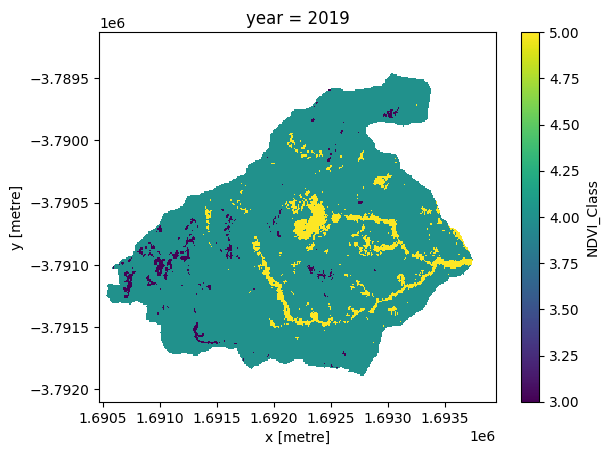

In [28]:
# Test plot
da_dict[list(da_dict.keys())[0]].plot()

### Annual class statistics

In [29]:
data = np.array([[int(da.where(da == cl).count().values) for cl in np.arange(1,7)] for name, da in da_dict.items()])*spatial_res**2/area_unit_val

In [30]:
df_annual_classes = pd.DataFrame(
    data = data,
    index=[key for key, val in da_dict.items()],
    columns = cl_labels
)

# Add a row total column
df_annual_classes['Total'] = df_annual_classes.sum(axis=1)

df_annual_classes

,Water,Bare,Sparse,Medium-density,High-density,Masked,Total
2019,0.0,0.00,9.22,400.89,29.52,0.0,439.63
2023,0.0,0.01,45.97,371.31,22.34,0.0,439.63


In [31]:
df_annual_classes_prop = df_annual_classes.div(df_annual_classes.Total, axis=0).round(3)*100
df_annual_classes_prop

,Water,Bare,Sparse,Medium-density,High-density,Masked,Total
2019,0.0,0.0,2.1,91.2,6.7,0.0,100.0
2023,0.0,0.0,10.5,84.5,5.1,0.0,100.0


### Annual class difference statistics

In [32]:
data = np.array([[int(da.where(da == cl).count().values) for name, da in da_dict.items()] for cl in np.arange(1,7)])*spatial_res**2/area_unit_val

In [33]:
df_annual_class_diff = pd.DataFrame(
    data = data,
    columns = [years[0], years[1]],
    index = cl_labels
)

# Add a difference column
df_annual_class_diff[str(years[1])+'-'+str(years[0])] = df_annual_class_diff[years[1]] - df_annual_class_diff[years[0]]

# Add a percentage change column
df_annual_class_diff['Change_%'] = (df_annual_class_diff[str(years[1])+'-'+str(years[0])]
                                    .div(df_annual_class_diff[years[0]], axis=0)
                                    .round(3)
                                    *100
                                   )

df_annual_class_diff

,2019,2023,2023-2019,Change_%
Water,0.00,0.00,0.00,NaN
Bare,0.00,0.01,0.01,inf
Sparse,9.22,45.97,36.75,398.6
Medium-density,400.89,371.31,-29.58,-7.4
High-density,29.52,22.34,-7.18,-24.3
Masked,0.00,0.00,0.00,NaN


### Class change matrix
This section investigates the change between classes between the current year and the previous year, and the current year and the mean of the previous five years.

In [34]:
r_index = pd.MultiIndex.from_product([[years[0]], cl_labels], names=['Year','Class'])
print(r_index)
c_index = pd.MultiIndex.from_product([[years[1]], cl_labels], names=['Year','Class'])
print(c_index)

MultiIndex([(2019,          'Water'),
            (2019,           'Bare'),
            (2019,         'Sparse'),
            (2019, 'Medium-density'),
            (2019,   'High-density'),
            (2019,         'Masked')],
           names=['Year', 'Class'])
MultiIndex([(2023,          'Water'),
            (2023,           'Bare'),
            (2023,         'Sparse'),
            (2023, 'Medium-density'),
            (2023,   'High-density'),
            (2023,         'Masked')],
           names=['Year', 'Class'])


In [35]:
def change_mat(arrs, cl_labels):
    '''
    Create a change matrix from a list of exactly two data arrays.
    The data array values represent classes for the same classification method.
    Rows will represent the first array and columns will represent the second array in the returned data frame.
    
    arrs: Two data arrays of the same size and shape.
    cl_labels: A list of all the class labels used in the classification. 
    There can be a maximum of 256 classes. 
    The label list needs to match the ascending order of the class numbers in the array values.
    '''
    
    # Create the pairs of corresponding class values
    tuples = (list(zip(arrs[0].values.reshape(-1), arrs[1].values.reshape(-1))))
    
    # Get the unique pairs and their frequencies
    # https://stackoverflow.com/a/51793947/8299958
    unique, counts = np.unique(tuples, axis=0, return_counts=True)
    
   
    # Strip pairs containing any nan
    sel = np.array(~np.isnan(unique).any(axis=1))
    counts = counts[sel]
    unique = unique[sel]
  
    
    # Create an empty matrix with dimensions equal to the number of classes
    num_cl = len(cl_labels)
    mat = np.zeros((num_cl,num_cl), dtype=np.int32)
    
    # Fill the matrix
    for n in np.arange(len(unique)):
        row = (unique[n][0]-1 ).astype(np.uint8) # row index
        col = (unique[n][1]-1 ).astype(np.uint8) # column index
        mat[row, col] = counts[n] # update the matrix

    # Create the multiindex
    r_index = pd.MultiIndex.from_product([[years[0]], cl_labels], names=['Year','Class'])
    c_index = pd.MultiIndex.from_product([[years[1]], cl_labels], names=['Year','Class'])

    
    # Create the data frame
    df = pd.DataFrame(
            data = mat*spatial_res**2/area_unit_val, # convert to area unit
            # index = cl_labels,
            # columns = cl_labels
            index = r_index,
            columns = c_index        
            )
    
    # Proportional data frame as a percentage of row total
    # https://stackoverflow.com/a/50820765/8299958
    df_prop = df.div(df.sum(axis=1), axis=0).round(3)*100
    
    return (df, df_prop)

In [36]:
change_mat_prev_curr = change_mat([da_dict[str(years[0])], da_dict[str(years[1])]], cl_labels)

In [37]:
change_mat_prev_curr[0]

Year                 2023                                                
Class               Water  Bare Sparse Medium-density High-density Masked
Year Class                                                               
2019 Water            0.0  0.00   0.00           0.00         0.00    0.0
     Bare             0.0  0.00   0.00           0.00         0.00    0.0
     Sparse           0.0  0.01   9.12           0.09         0.00    0.0
     Medium-density   0.0  0.00  36.85         353.30        10.74    0.0
     High-density     0.0  0.00   0.00          17.92        11.60    0.0
     Masked           0.0  0.00   0.00           0.00         0.00    0.0

In [38]:
change_mat_prev_curr[1]

Year                 2023                                               
Class               Water Bare Sparse Medium-density High-density Masked
Year Class                                                              
2019 Water            NaN  NaN    NaN            NaN          NaN    NaN
     Bare             NaN  NaN    NaN            NaN          NaN    NaN
     Sparse           0.0  0.1   98.9            1.0          0.0    0.0
     Medium-density   0.0  0.0    9.2           88.1          2.7    0.0
     High-density     0.0  0.0    0.0           60.7         39.3    0.0
     Masked           NaN  NaN    NaN            NaN          NaN    NaN

### Class Change Map

In [39]:
# Pandas data frame of change class labels
df_ch_cl = pd.DataFrame(
               data = [(x,y) for x in np.arange(1,7) for y in np.arange(1,7)],
               columns = ['cl0','cl1']
)

# Create the change labels
df_ch_cl['ch_cl_label'] = [cl_labels[df_ch_cl.cl0[i]-1] +' --> '+cl_labels[df_ch_cl.cl1[i]-1] for i in df_ch_cl.index]
df_ch_cl.loc[[df_ch_cl.cl0[i] == df_ch_cl.cl1[i] for i in df_ch_cl.index], 'ch_cl_label'] = 'No Change'

# Create the change class numbers column
df_ch_cl['ch_cl_num'] = 0

# All 'No Change' should be class 0
# Locate the changed classes
changed = np.array([df_ch_cl.cl0[i] != df_ch_cl.cl1[i] for i in df_ch_cl.index])
# Create a list of numbers for the changed classes
cl_nums = np.arange(changed.sum())+1

# Iterate to add cl_nums to changed classes; leave 'No Change' = 0
i = 0
j = 0
while i < len(df_ch_cl.index):
    if changed[i]:
        df_ch_cl.loc[i,'ch_cl_num'] = cl_nums[j]
        j += 1
    i += 1

# Add an Missing class
# nan = -999 requied since np.nan == np.nan --> False
df_nan = pd.DataFrame({'cl0':-999, 'cl1':-999, 'ch_cl_label':'Missing', 'ch_cl_num':df_ch_cl.ch_cl_num.max()+1},
                     index=[0])
df_ch_cl = pd.concat([df_ch_cl, df_nan], axis=0, ignore_index=True)


df_ch_cl

,cl0,cl1,ch_cl_label,ch_cl_num
0,1,1,No Change,0
1,1,2,Water --> Bare,1
2,1,3,Water --> Sparse,2
3,1,4,Water --> Medium-density,3
4,1,5,Water --> High-density,4
5,1,6,Water --> Masked,5
6,2,1,Bare --> Water,6
7,2,2,No Change,0
8,2,3,Bare --> Sparse,7
9,2,4,Bare --> Medium-density,8


#### Data frame of tuples

In [40]:
df_tuples = pd.DataFrame(
    {'cl0':da_dict[str(years[0])].values.reshape(-1), 'cl1':da_dict[str(years[1])].values.reshape(-1)}
)

# Convert nan to np.nan to match df_ch_cl.ch_cl_pairs
df_tuples = df_tuples.fillna(-999)

df_tuples

,cl0,cl1
0,-999.0,-999.0
1,-999.0,-999.0
2,-999.0,-999.0
3,-999.0,-999.0
4,-999.0,-999.0
...,...,...
103351,-999.0,-999.0
103352,-999.0,-999.0
103353,-999.0,-999.0
103354,-999.0,-999.0


In [41]:
df_tuples.shape

(103356, 2)

#### Merge df_tuples with df_ch_cl using ch_cl_pairs

In [42]:
# Must include how='left' to maintain original order
df_ch_map = df_tuples.merge(df_ch_cl, how='left')
df_ch_map.head()

,cl0,cl1,ch_cl_label,ch_cl_num
0,-999.0,-999.0,Missing,31
1,-999.0,-999.0,Missing,31
2,-999.0,-999.0,Missing,31
3,-999.0,-999.0,Missing,31
4,-999.0,-999.0,Missing,31


In [43]:
df_ch_map.shape

(103356, 4)

#### Create the change map data array

In [44]:
da_change_map = xr.DataArray(
    data = np.array(df_ch_map.ch_cl_num).reshape(ds.NDVI_Class.shape[1:]),
    coords = {'y':ds.NDVI_Class.coords['y'], 'x':ds.NDVI_Class.coords['x']}
)

# Set the crs
da_change_map = da_change_map.rio.write_crs(crs)

da_change_map

<xarray.DataArray (y: 297, x: 348)>
array([[31, 31, 31, ..., 31, 31, 31],
       [31, 31, 31, ..., 31, 31, 31],
       [31, 31, 31, ..., 31, 31, 31],
       ...,
       [31, 31, 31, ..., 31, 31, 31],
       [31, 31, 31, ..., 31, 31, 31],
       [31, 31, 31, ..., 31, 31, 31]], dtype=int64)
Coordinates:
  * y            (y) float64 -3.789e+06 -3.789e+06 ... -3.792e+06 -3.792e+06
  * x            (x) float64 1.69e+06 1.69e+06 1.69e+06 ... 1.694e+06 1.694e+06
    spatial_ref  int32 0

#### Change Map Plot

In [45]:
# Get the unique ch_cl_nums
ch_cl_num_unq = np.unique(da_change_map.values)

# Set axis tick locations halfway between ch_cl_num
ax_tick_loc = [(ch_cl_num_unq[i]+ch_cl_num_unq[i+1])/2 for i in np.arange(len(ch_cl_num_unq)-1)]

# Exclude the highest ch_cl_num because it is the Missing class
ax_tick_labels = np.array(df_ch_cl.ch_cl_label[df_ch_cl.ch_cl_num.isin(ch_cl_num_unq[:-1])].unique())

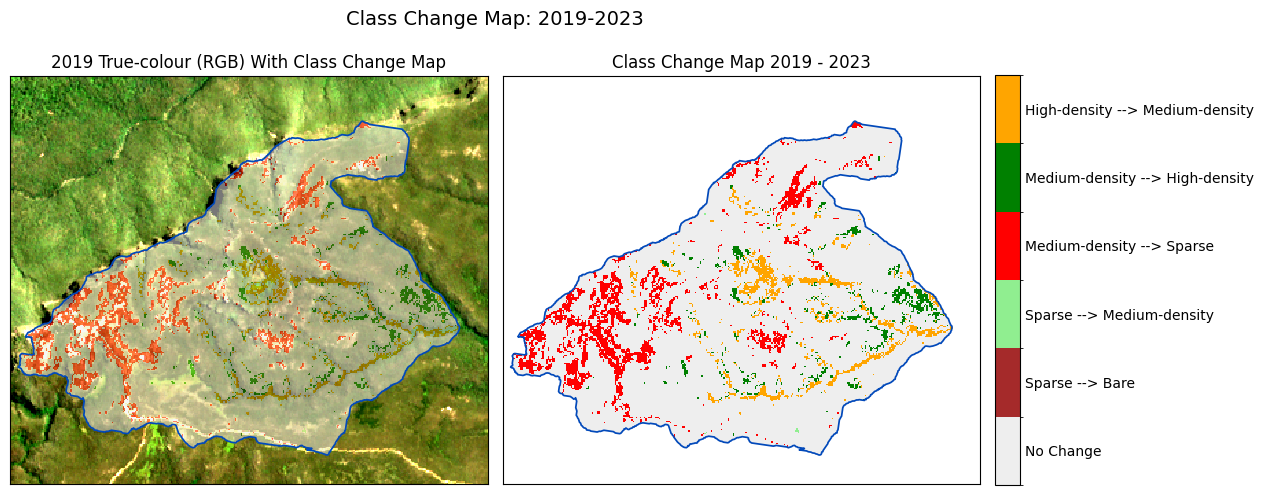

In [52]:
# alpha value for RGB plot overlay
alpha = 0.5

# Class colours
colors=['#EEEEEE', 
        'brown', 
        'lightgreen',
        'red', 
        'green', 
        'orange',
       ]

fig, axes = plt.subplots(1,2,figsize=(10,5))

(ds[rgb_vars]
     .isel(year=0)
     .to_array()
     .plot
     .imshow(ax=axes[0], **rgb_params)
)

da_change_map.plot(ax=axes[0], 
                            add_colorbar=False,
                            levels=ch_cl_num_unq,  
                            # cmap='tab10' # Try this first, then set some custom colours
                            # Custom colours; second element of tuple is alpha
                            colors=[(color, alpha) for color in colors]
                           )

axes[0].set_title(str(years[0])+' True-colour (RGB) With Class Change Map')


colour = da_change_map.plot(ax=axes[1], 
                   add_colorbar=False,
                   levels=ch_cl_num_unq,  
                   # cmap='tab10'
                 # Custom colours; second element of tuple is alpha
                 colors= colors
                 )

axes[1].set_title('Class Change Map '+str(years[0])+' - '+str(years[1]))


for ax in fig.axes:
    remove_labels_ticks(ax)
    # ax.set_title('Class Change Map: '+str(years[0])+'-'+str(years[1]), fontsize=14)
    poly.boundary.plot(ax=ax, linewidth=1.25, color='#0249ba')


# Add colorbar - Vertical at side
cax = fig.add_axes([1, 0.09, 0.025, 0.82])
cb = fig.colorbar(
                          colour, 
                          cax=cax, 
                          orientation = 'vertical', 
                         )

cb.set_ticks(ax_tick_loc)
cb.set_ticklabels(ax_tick_labels)
cb.ax.tick_params(size=0)
# cb.set_label('Change Class', fontsize=11)


fig.tight_layout()
fig.suptitle('Class Change Map: '+str(years[0])+'-'+str(years[1]), y=1.04, fontsize=14)

# bbox_inches = "tight" is required to stop labels at edges being cut off
# https://stackoverflow.com/questions/35992492/savefig-cuts-off-title
fig.savefig(img_dir+'NDVI_Class_change_plot_'+str(years[0])+'-'+str(years[1])+'.png', dpi=600, bbox_inches = "tight");

plt.show()
plt.close('all')

## Export Data

In [53]:
da_change_map.rio.to_raster(geotiff_dir+study_area_abbrev+'_change_map.tiff')